In [1]:
import keras
from keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
datagen = image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.2,
    fill_mode='reflect',
    rotation_range=20,
    horizontal_flip=True
    )

#datagen.fit(X_train)

In [3]:
image_dir = "skin-images"
data_df = pd.read_csv('skin_condition_label1.csv')

In [4]:
data_df.head()

,Unnamed: 0,file_id,1_texture,1_pores,1_spot,1_saggy,1_clear,1_melanin,1_wrinkles
0,0,1.jpg,3,2,3,3,4,3,3
1,1,6.jpg,4,4,1,4,2,1,4
2,2,7.jpg,3,3,2,3,3,2,4
3,3,8.jpg,2,3,1,2,1,1,1
4,4,9.jpg,3,2,3,3,3,3,2


In [5]:
# Parameters
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE= (224, 224, 3)

train_df, test_df = train_test_split(data_df, random_state = 80, test_size=0.2)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory = image_dir,
    x_col = "file_id",
    y_col = ["1_texture","1_pores","1_spot","1_saggy","1_clear","1_melanin","1_wrinkles"],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory = image_dir,
    x_col = "file_id",
    y_col = ["1_texture","1_pores","1_spot","1_saggy","1_clear","1_melanin","1_wrinkles"],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

Found 1316 validated image filenames.
Found 330 validated image filenames.


[3 3 2 3 2 1 3]


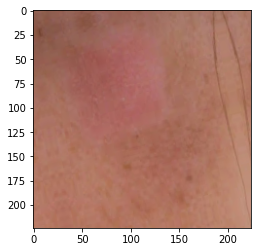

In [6]:
plt.imshow(test_generator[0][0][3])
print(test_generator[0][1][3])

In [7]:
densenet = tf.keras.applications.DenseNet169(
    include_top = False, 
    weights = "imagenet",
    input_shape = INPUT_SHAPE
    )
densenet.Trainable = False
x = GlobalAveragePooling2D()(densenet.output)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(units = 64, activation = 'relu')(x)
pred = Dense(units = 7, activation = 'softmax', kernel_regularizer = l2(l = 0.01))(x)
model = keras.models.Model(inputs = densenet.input, outputs = pred)

model.load_weights('./tmp/finalresult/densenet_skin_finetuned_best.h5')


In [8]:
x = model.layers[-8].output
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(7, activation='relu')(x)
model = keras.models.Model(inputs = model.input, outputs = output)

In [9]:
#newmodel.summary()

In [10]:
model.compile(optimizer='adam', loss='mse', metrics=['mae','accuracy'])

In [11]:
checkpoint_filepath = './tmp/checkpoint(transfer)/cp-{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    period=1,
    mode='auto',
    save_best_only=False)

In [12]:
# Fit model
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = test_generator,
    callbacks=[model_checkpoint_callback]
  )

Epoch 1/30
42/42 [==============================] - 19s 441ms/step - loss: 2.5269 - mae: 1.2644 - accuracy: 0.1839 - val_loss: 2.3524 - val_mae: 1.2503 - val_accuracy: 0.4848
Epoch 2/30
42/42 [==============================] - 14s 336ms/step - loss: 1.3282 - mae: 0.8520 - accuracy: 0.4597 - val_loss: 1.7211 - val_mae: 1.0464 - val_accuracy: 0.3606
Epoch 3/30
42/42 [==============================] - 14s 331ms/step - loss: 1.0114 - mae: 0.7407 - accuracy: 0.5122 - val_loss: 1.2879 - val_mae: 0.9121 - val_accuracy: 0.5000
Epoch 4/30
42/42 [==============================] - 14s 335ms/step - loss: 0.7751 - mae: 0.6532 - accuracy: 0.5213 - val_loss: 1.4859 - val_mae: 1.0314 - val_accuracy: 0.6242
Epoch 5/30
42/42 [==============================] - 14s 338ms/step - loss: 0.5405 - mae: 0.5774 - accuracy: 0.5707 - val_loss: 0.8797 - val_mae: 0.7718 - val_accuracy: 0.7000
Epoch 6/30
42/42 [==============================] - 14s 336ms/step - loss: 0.4602 - mae: 0.5385 - accuracy: 0.6269 - val_loss

In [13]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae     = history.history['mae']
val_mae = history.history['val_mae']

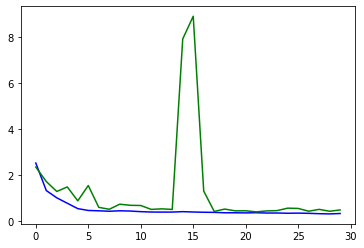

In [14]:
epochs = range(len(loss))
plt.plot(epochs,loss,"b",label="Training loss")
plt.plot(epochs,val_loss,"g",label="validation loss")

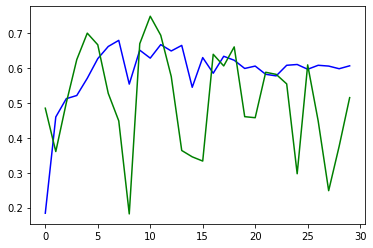

In [15]:
plt.plot(epochs,acc,"b",label="Training accuracy")
plt.plot(epochs,val_acc,"g",label="validation accuracy")

In [17]:
max(val_acc)
val_acc.index(max(val_acc))

10

In [16]:
img = image.load_img("2000.jpg",target_size=(100,100,3))
img = image.img_to_array(img)
img = img/255
actual_score = [3, 3, 3, 4, 3, 3, 4]

In [17]:
model.predict(img.reshape(1,100,100,3))

array([[3.0481951, 2.6301398, 2.4831243, 2.573582 , 2.3544223, 2.462579 ,
        2.8164535]], dtype=float32)

In [18]:
model.predict(test_generator[0][0][3].reshape(1,100,100,3))

array([[2.5489972, 1.8497462, 2.3557734, 2.5723727, 2.151544 , 2.2600727,
        2.4208775]], dtype=float32)

In [19]:
test_generator[0][1][3]

array([4, 3, 2, 4, 2, 2, 4], dtype=int64)